# Module 13 Lab - Rule Based Machine Learning

## Directions

1. Show all work/steps/calculations. Generate a Markdown/code cells for each answer.
2. You must submit your lab by the deadline to the Lab section of the Course Module where you downloaded this file from.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [7]:
!pip install pydotplus

  Using cached https://files.pythonhosted.org/packages/60/bf/62567830b700d9f6930e9ab6831d6ba256f7b0b730acb37278b0ccdffacf/pydotplus-2.0.2.tar.gz
  Running setup.py bdist_wheel for pydotplus: started
  Running setup.py bdist_wheel for pydotplus: finished with status 'done'
  Stored in directory: C:\Users\Yichen\AppData\Local\pip\Cache\wheels\35\7b\ab\66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


You are using pip version 9.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [18]:
!pip install graphviz

You are using pip version 9.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [39]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import models
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

sns.set(style="whitegrid")

In [2]:
import graphviz

We talked about a wide variety of algorithms this module but we're going to concentrate on just two: Decision Trees and Random Forests.

**Problem 1.**

Using the insurance data set, construct a Decision Tree to estimate charges using the Scikit Learn Library [Decision Tree](https://scikit-learn.org/stable/modules/tree.html). You should use validation curves to estimate the best tree depth. With this tree depth, perform 3 rounds of 10 fold cross validation to get a sense of generalization error and learning curves to estimate bias/variance trade-off.

Visualize the tree if possible. 

Compare with your linear regression results. Use Bayesian inference to test the difference of means.

In [3]:
data = pd.read_csv('insurance.csv')

In [4]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [14]:
X = data.loc[:,'age':'region']
X = pd.get_dummies(X)
y = data.loc[:,'charges']
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42)
r_scores = []
for i in range(1,11):
    clf = tree.DecisionTreeRegressor(max_depth = i)
    clf = clf.fit(X_train,y_train)
    r = clf.score(X_test,y_test)
    r_scores.append(r)

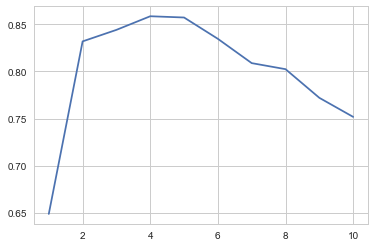

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(1,11),r_scores)
plt.show()
plt.close()

It appears that a tree depth of 4 gives the greatest r^2 on the test dataset.

In [27]:
clf = tree.DecisionTreeRegressor(max_depth = 4)
r_scores2 = []
sigmas=[]
for i in range(3):
    kf = KFold(n_splits=10, random_state = i, shuffle = True)
    for train_index,test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,],X.iloc[test_index,]
        y_train,y_test = y[train_index],y[test_index]
        clf.fit(X_train,y_train)
        r_scores2.append(clf.score(X_test,y_test))
        sigmas.append(np.sqrt(mean_squared_error(y_test,clf.predict(X_test))))

In [28]:
stats.mstats.mquantiles( r_scores2, [0.05, 0.95])

array([0.76775093, 0.90318345])

In [29]:
stats.mstats.mquantiles( sigmas, [0.05, 0.95])

array([3996.19573446, 6171.48800519])

It appears that the 90% CI for R^2 is between .76 and .90, and the 90% CI for sigmas is between 3996 and 6171.

### Validation Curve

In [34]:
sigma_train = []
sigma_test = []
for i in np.linspace(.05,1,20):
    data2 = data.sample(frac=i)
    X = data2.loc[:,'age':'region']
    X = pd.get_dummies(X)
    y = data2.loc[:,'charges']
    X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42)
    clf = tree.DecisionTreeRegressor(max_depth = 4)
    clf = clf.fit(X_train,y_train)
    sigma_train.append(np.sqrt(mean_squared_error(y_train,clf.predict(X_train))))
    sigma_test.append(np.sqrt(mean_squared_error(y_test,clf.predict(X_test))))

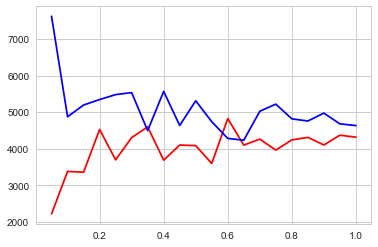

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(.05,1,20),sigma_train,color = 'red')
ax.plot(np.linspace(.05,1,20),sigma_test,color = 'blue')
plt.show()
plt.close()

It seems that we are in a high bias zone, and that getting additional data will not help the model that much. 

In [38]:
data2 = pd.get_dummies(data)
regression = models.bootstrap_linear_regression('charges ~ age + bmi + sex_female + sex_male + smoker_no + smoker_yes + region_northeast + region_northwest+region_southwest',data=data2)
models.describe_bootstrap_lr(regression)

It appears that compared to the linear regression, the R^2 is slightly more varied in the decision tree, but it seems like the error might be smaller .

In [6]:
# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

InvocationException: GraphViz's executables not found

I can't figure out GraphViz unfortunately

** Problem 2.**

Now use the [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) on the insurance data set. Use validation curves to optimize the hyperparameters. Estimate generalization error on 3 rounds of 10 fold cross validation. Instead of learning curves, examine the importance of the features. How does this compare with your linear regression from before?

In [40]:
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)

In [43]:
X = data.loc[:,'age':'region']
X = pd.get_dummies(X)
y = data.loc[:,'charges']
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42)
r_scores = []
for i in range(1,11):
    regr = RandomForestRegressor(max_depth=i, random_state=0,n_estimators=100)
    regr = regr.fit(X_train,y_train)
    r = regr.score(X_test,y_test)
    r_scores.append(r)

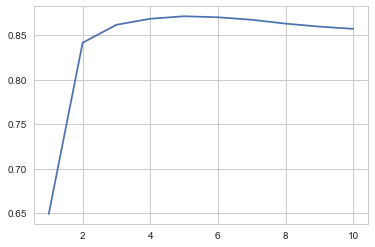

In [44]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(1,11),r_scores)
plt.show()
plt.close()

It seems that around a depth of 5 is where the R^2 is the highest.

In [45]:
regr = RandomForestRegressor(max_depth=5, random_state=0,n_estimators=100)
r_scores2 = []
sigmas=[]
for i in range(3):
    kf = KFold(n_splits=10, random_state = i, shuffle = True)
    for train_index,test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,],X.iloc[test_index,]
        y_train,y_test = y[train_index],y[test_index]
        regr.fit(X_train,y_train)
        r_scores2.append(regr.score(X_test,y_test))
        sigmas.append(np.sqrt(mean_squared_error(y_test,regr.predict(X_test))))

In [46]:
stats.mstats.mquantiles( r_scores2, [0.05, 0.95])

array([0.78352763, 0.91066886])

In [47]:
stats.mstats.mquantiles( sigmas, [0.05, 0.95])

array([3738.45775523, 6054.18288136])

It looks like the 90% CI for r^2 is .78 to .91, while the 90% CI for sigmas is between 3738 and 6054.

In [48]:
sigma_train = []
sigma_test = []
for i in np.linspace(.05,1,20):
    data2 = data.sample(frac=i)
    X = data2.loc[:,'age':'region']
    X = pd.get_dummies(X)
    y = data2.loc[:,'charges']
    X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42)
    regr = RandomForestRegressor(max_depth=5, random_state=0,n_estimators=100)
    regr = regr.fit(X_train,y_train)
    sigma_train.append(np.sqrt(mean_squared_error(y_train,regr.predict(X_train))))
    sigma_test.append(np.sqrt(mean_squared_error(y_test,regr.predict(X_test))))

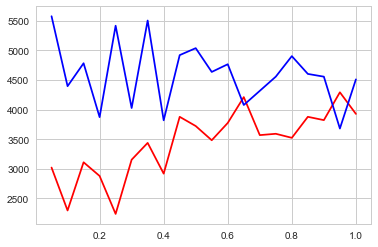

In [49]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(.05,1,20),sigma_train,color = 'red')
ax.plot(np.linspace(.05,1,20),sigma_test,color = 'blue')
plt.show()
plt.close()

It seems like we were initially in a high variance environment, however we are now in a high bias environment and additional data will not help

In [53]:
regr.feature_importances_

array([0.11855896, 0.18585994, 0.00749473, 0.00047908, 0.00053071,
       0.27362231, 0.40944854, 0.00175202, 0.00096151, 0.00084721,
       0.00044499])

In [55]:
importances = []
for i in np.linspace(.05,1,20):
    data2 = data.sample(frac=i)
    X = data2.loc[:,'age':'region']
    X = pd.get_dummies(X)
    y = data2.loc[:,'charges']
    X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42)
    regr = RandomForestRegressor(max_depth=5, random_state=0,n_estimators=100)
    regr = regr.fit(X_train,y_train)
    importances.append(regr.feature_importances_)

In [57]:
pd.DataFrame(importances)

,0,1,2,3,4,5,6,7,8,9,10
0,0.195670,0.119012,0.087152,0.002680,0.004019,0.367934,0.166930,0.001338,0.005400,0.043830,0.006035
1,0.168173,0.255990,0.007538,0.001926,0.002301,0.262951,0.282704,0.005119,0.001889,0.002781,0.008629
2,0.134626,0.167586,0.017997,0.002074,0.000779,0.502936,0.160512,0.002327,0.001530,0.008696,0.000936
3,0.119618,0.162211,0.013698,0.001920,0.002132,0.364315,0.326486,0.005064,0.001422,0.002454,0.000680
4,0.080869,0.196716,0.015039,0.001557,0.001553,0.337370,0.358083,0.003369,0.002897,0.001314,0.001233
5,0.141164,0.196837,0.015505,0.001516,0.001977,0.138646,0.489448,0.001025,0.006638,0.002746,0.004498
6,0.112123,0.203951,0.024257,0.001669,0.001067,0.147816,0.497434,0.005429,0.002290,0.003055,0.000909
7,0.153904,0.164190,0.013709,0.001683,0.000965,0.202520,0.456266,0.001205,0.001791,0.001280,0.002487
8,0.147236,0.177660,0.013304,0.000772,0.001162,0.085721,0.567772,0.001844,0.002695,0.001383,0.000450
9,0.133254,0.173869,0.009878,0.000277,0.000521,0.289901,0.384618,0.003269,0.001015,0.001585,0.001813


In [58]:
pd.DataFrame(importances).mean()

0     0.131368
1     0.180106
2     0.015803
3     0.001128
4     0.001165
5     0.290539
6     0.369517
7     0.002634
8     0.002028
9     0.003899
10    0.001814
dtype: float64

It appears that there's some variability in feature importances. On average, the 5th and 6th variables are the most important, with the 3rd, 4th, 7th, 8th, 9th, and 10th variables barely being important at all.